## Importing packages

In [1]:
# Importing the required packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
import concurrent.futures
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sns

## Data import and cleaning

In [2]:
# List to hold DataFrames
dataframes = []

# Loop to read in the files and filter the rows
for i in range(1, 6):
    filename = f'final_dat_{i}.csv'
    temp_df = pd.read_csv(filename)
    
    # Filter rows where column 'B' has values 1.3, 1.4, or 1.5
    filtered_df = temp_df[temp_df['B'].isin([1.3, 1.4, 1.5])]
    
    # Append the filtered DataFrame to the list
    dataframes.append(filtered_df)

# Combine all filtered DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

print(len(df))
# Check for and handle NaNs in the dataset
df.dropna(inplace=True)  # Remove rows with NaNs

# Split the entire DataFrame into training+validation and test sets (80% train + val, 20% test)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract features and targets from the training+validation set
train_val_features = train_val_df[['T', 'K', 'B', 'sigma_tk']]
train_val_targets = train_val_df['UI Barrier Price']

# Extracting call option prices - will be used as a constraint in the obj func
train_val_call_prices = train_val_df['Call Price']


# Convert the split data into PyTorch tensors
train_val_features_tensor = torch.tensor(train_val_features.values, dtype=torch.float32)
train_val_targets_tensor = torch.tensor(train_val_targets.values, dtype=torch.float32).view(-1, 1)
train_val_call_prices_tensor = torch.tensor(train_val_call_prices.values, dtype=torch.float32).view(-1, 1)

# Wrap the train and validation tensors in TensorDataset
train_val_dataset = TensorDataset(train_val_features_tensor, train_val_targets_tensor, train_val_call_prices_tensor)


60750


## Defining the simple Neural Network

In [3]:
# Define your model class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

## Definition of fixed hyper-parameters

In [4]:
# Define fixed hyperparameters
hidden_size = 5  
fixed_lr = 0.01
batch_number = 128
num_epochs = 30


# Defining the range for the L1 and L2 penalty constants
# L2 leads to much smaller sum of weights, so we operate this on a higher scale
l1_lambdas = np.logspace(-6, -4, 4)
l2_lambdas = np.logspace(-6, -4, 4)

# Defining the upper and lower bound constraint penalty constant
Lower_pen_range = np.logspace(-6,-1,4)
Upper_pen_range = np.logspace(-6,-1,4)

# Defining variables to store optimal 
best_loss = float('inf')
best_params = {}
best_model = None



## Model Training

In [8]:
# Dictionary to store validation losses for each combination of L1 and L2
val_loss_history = {}

# Split dataset into training and validation sets
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_number, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_number, shuffle=False)

for l1 in l1_lambdas:
    for l2 in l2_lambdas:
        for Upper_pen in Lower_pen_range:
            for Lower_pen in Upper_pen_range:
                model = SimpleNN(input_size=4, hidden_size=hidden_size, output_size=1)
                optimizer = optim.Adam(model.parameters(), lr=fixed_lr, weight_decay=l2)
                criterion = nn.MSELoss()

                for epoch in range(num_epochs):
                    # Train model
                    model.train()
                    for inputs, barrier_prices, call_prices in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, barrier_prices)

                        # L1 regularization penalty
                        l1_penalty = l1 * sum(p.abs().sum() for p in model.parameters())
                        loss += l1_penalty

                        # Upper and lower bound penalties
                        upper_penalty = Upper_pen * torch.sum(torch.clamp(outputs - call_prices, min=0) ** 2)
                        lower_penalty = Lower_pen * torch.sum(torch.clamp(0 - outputs, min=0) ** 2)
                        total_penalty = upper_penalty + lower_penalty

                        loss += total_penalty

                        # Backpropagation and optimizer step
                        loss.backward()
                        optimizer.step()

                # Validate model
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for inputs, barrier_prices, call_prices in val_loader:
                        outputs = model(inputs)
                        loss = criterion(outputs, barrier_prices)
                        val_losses.append(loss.item())

                mean_val_loss = np.mean(val_losses)
                val_loss_history[(l1, l2, Upper_pen, Lower_pen)] = mean_val_loss  

                # Print the lambda values, penalties, and mean validation loss for this combination
                print(f"L1: {l1:.8f}, L2: {l2:.8f},upper: {Upper_pen:.8f},lower: {Lower_pen:.8f}, Mean Validation Loss: {mean_val_loss:.6f}")

                if mean_val_loss < best_loss:
                    best_loss = mean_val_loss
                    best_params = {'l1': l1, 'l2': l2, 'upper': Upper_pen, 'lower': Lower_pen}
                    best_model = model

print(f"Best Parameters: {best_params}")
print(f"Best Validation Loss: {best_loss:.6f}")

KeyboardInterrupt: 

## Plotting Validation Curves

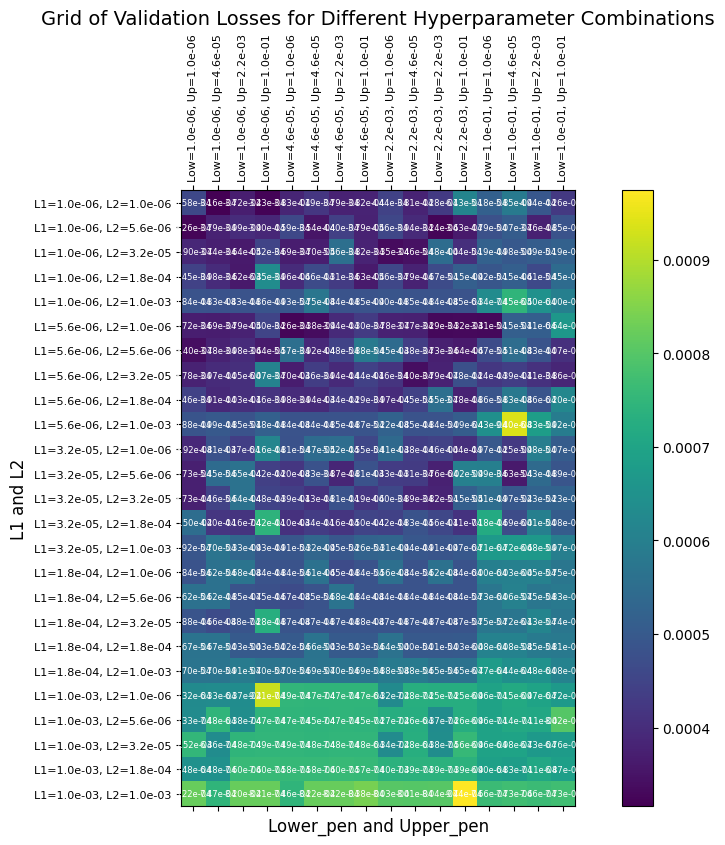

In [11]:
# Create a list of all possible combinations of the hyperparameters
combinations = list(itertools.product(l1_lambdas, l2_lambdas, Lower_pen_range, Upper_pen_range))

# Create a DataFrame to store the results
results_df = pd.DataFrame(combinations, columns=['L1', 'L2', 'Lower_pen', 'Upper_pen'])

# Add a column for the validation loss corresponding to each combination
results_df['Validation_Loss'] = results_df.apply(lambda row: val_loss_history[(row['L1'], row['L2'], row['Lower_pen'], row['Upper_pen'])], axis=1)

# Create a pivot table for better visualization
pivot_table = results_df.pivot_table(index=['L1', 'L2'], columns=['Lower_pen', 'Upper_pen'], values='Validation_Loss')

# Plotting the grid
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(pivot_table, cmap='viridis', interpolation='nearest')

# Set axis labels
ax.set_xticks(range(len(pivot_table.columns)))
ax.set_yticks(range(len(pivot_table.index)))

# Set tick labels
ax.set_xticklabels([f'Low={col[0]:.1e}, Up={col[1]:.1e}' for col in pivot_table.columns], rotation=90, fontsize=8)
ax.set_yticklabels([f'L1={row[0]:.1e}, L2={row[1]:.1e}' for row in pivot_table.index], fontsize=8)

# Adding the validation loss values to each cell
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        value = pivot_table.iloc[i, j]
        ax.text(j, i, f'{value:.2e}', va='center', ha='center', color='white', fontsize=6)

# Add a color bar for the heatmap
fig.colorbar(cax)

plt.title('Grid of Validation Losses for Different Hyperparameter Combinations', fontsize=14)
plt.xlabel('Lower_pen and Upper_pen', fontsize=12)
plt.ylabel('L1 and L2', fontsize=12)
plt.show()

## Retraining the model with the best hyper-parameters

In [5]:
l1_level = 1*10**(-6)
l2_level = 1*10**(-6)
upper_level = 1*10**(-6)
lower_level = 4.6415889*10**(-5)

best_params = {'l1': l1_level, 'l2': l2_level, 'upper': upper_level, 'lower': lower_level}


In [10]:
# Define fixed hyperparameters
hidden_size = 5  
fixed_lr = 0.01
batch_number = 128
num_epochs = 30

# Retrain the best model on the full train_val dataset
full_train_loader = DataLoader(train_val_dataset, batch_size=batch_number, shuffle=True)
best_model = SimpleNN(input_size=4, hidden_size=hidden_size, output_size=1)
best_model.train()

# Define the criterion and optimizer
criterion = nn.MSELoss()  # Example loss function, modify as needed
optimizer = optim.Adam(best_model.parameters(), lr=fixed_lr)

for epoch in range(num_epochs):
    for inputs, prices, call_prices in full_train_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, prices) + best_params['l1'] * sum(p.abs().sum() for p in best_model.parameters())
        # Upper and lower bound penalties
        upper_penalty = best_params['upper'] * torch.sum(torch.clamp(outputs - call_prices, min=0) ** 2)
        lower_penalty = best_params['lower'] * torch.sum(torch.clamp(0 - outputs, min=0) ** 2)
        total_penalty = upper_penalty + lower_penalty

        loss += total_penalty
        loss.backward()
        optimizer.step()

## Generate Response Curves

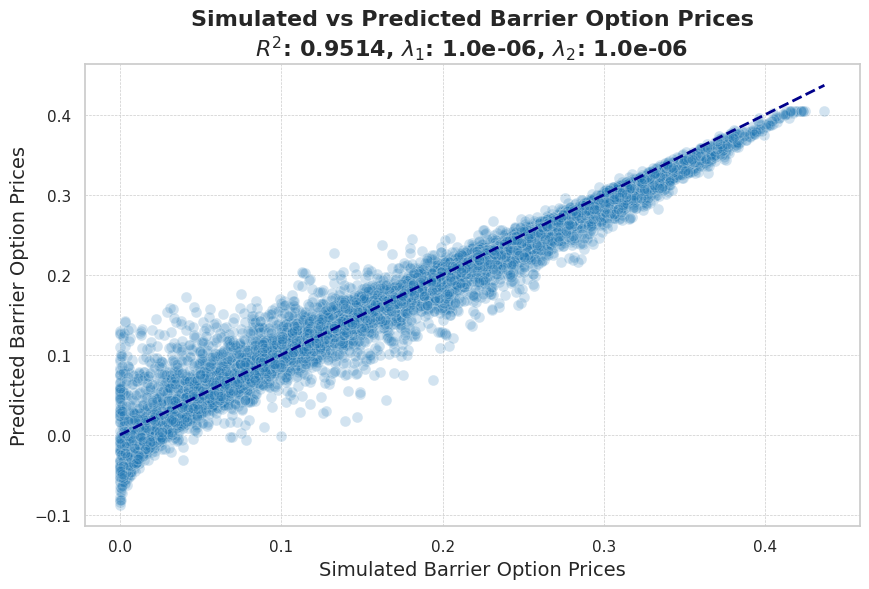

In [11]:
# Extracting only the elements of the Test set that we need to draw the response curves
test_df_NN_features = test_df[['T', 'K', 'B', 'sigma_tk']]
test_df_NN_targets = test_df['UI Barrier Price']
test_df_volatilities = test_df['sigma_tk'] 

# Converting to tensors and wrapping
test_df_features_tensor = torch.tensor(test_df_NN_features.values, dtype=torch.float32)
test_df_targets_tensor = torch.tensor(test_df_NN_targets.values, dtype=torch.float32).view(-1, 1)
test_df_volatilities_tensor = torch.tensor(test_df_volatilities.values, dtype=torch.float32).view(-1, 1)

test_df_NN_dataset = TensorDataset(test_df_features_tensor, test_df_targets_tensor, test_df_volatilities_tensor)

# Generate response curves
test_loader = DataLoader(test_df_NN_dataset, batch_size=32, shuffle=False)
predictions = []
actuals = []
volatilities = []
best_model.eval()
with torch.no_grad():
    for inputs, prices, vols in test_loader:
        outputs = best_model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(prices.numpy())
        volatilities.extend(vols.numpy()) 

# Convert predictions and actuals to numpy arrays
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()
volatilities = np.array(volatilities).flatten()

# Compute R^2 value
r2 = r2_score(actuals, predictions)

# Define lambda values (example)
lambda1 = best_params["l1"]
lambda2 = best_params["l2"]

# Initialize seaborn with a specific style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot with slightly darker light blue points and alpha=0.2
sns.scatterplot(x=actuals, y=predictions, color='#1f77b4', alpha=0.2, s=60)

# x=y line in dark blue
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color='darkblue', linestyle='--', lw=2)

# Set labels and title with matching font
plt.xlabel('Simulated Barrier Option Prices', fontsize=14)
plt.ylabel('Predicted Barrier Option Prices', fontsize=14)
plt.title(f'Simulated vs Predicted Barrier Option Prices\n$R^2$: {r2:.4f}, $\\lambda_1$: {lambda1:.1e}, $\\lambda_2$: {lambda2:.1e}', fontsize=16, fontweight='bold')

# Enhance the grid and set the grid style
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Show the plot
plt.show()




In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = pd.DataFrame({
    'Actual Density': actuals,
    'Predicted Density': predictions,
    'Volatility': volatilities  # Assuming 'volatilities' is a list or array of volatilities corresponding to the actuals and predictions
})

# Categorize volatility into low and high
data['Volatility Category'] = data['Volatility'].apply(lambda x: 'Lower Volatility (<0.3)' if x < 0.3 else 'Higher Volatility (>=0.3)')

# Melt the data for easier plotting
data_melted = pd.melt(data, id_vars=['Volatility Category'], value_vars=['Actual Density', 'Predicted Density'], 
                      var_name='Density Type', value_name='Density')

# Set a higher DPI for better resolution
plt.figure(figsize=(12, 6), dpi=1000)

# Apply a more refined palette and set seaborn style
sns.set(style="whitegrid", palette="Set2", font_scale=1.2)

# Create the violin plot with high-quality rendering options
sns.violinplot(x='Density Type', y='Density', hue='Volatility Category', data=data_melted, 
               inner="quartiles", linewidth=2, cut=0, palette="Blues")

# Set labels with improved font properties
plt.ylabel('Barrier Option Prices', fontsize=14, fontweight='bold')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


In [76]:

# Example data
data = pd.DataFrame({
    'Actual Density': actuals,
    'Predicted Density': predictions
})

# Set a higher DPI for better resolution
plt.figure(figsize=(12, 6), dpi=1000)

# Apply a more refined palette and set seaborn style
sns.set(style="whitegrid", palette="Set2", font_scale=1.2)

# Create the violin plot with high-quality rendering options
sns.violinplot(data=data, inner="quartiles", linewidth=2, cut=0, palette = 'Blues')

# Set labels with improved font properties
plt.ylabel('Barrier Option Prices', fontsize=14, fontweight='bold')


# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

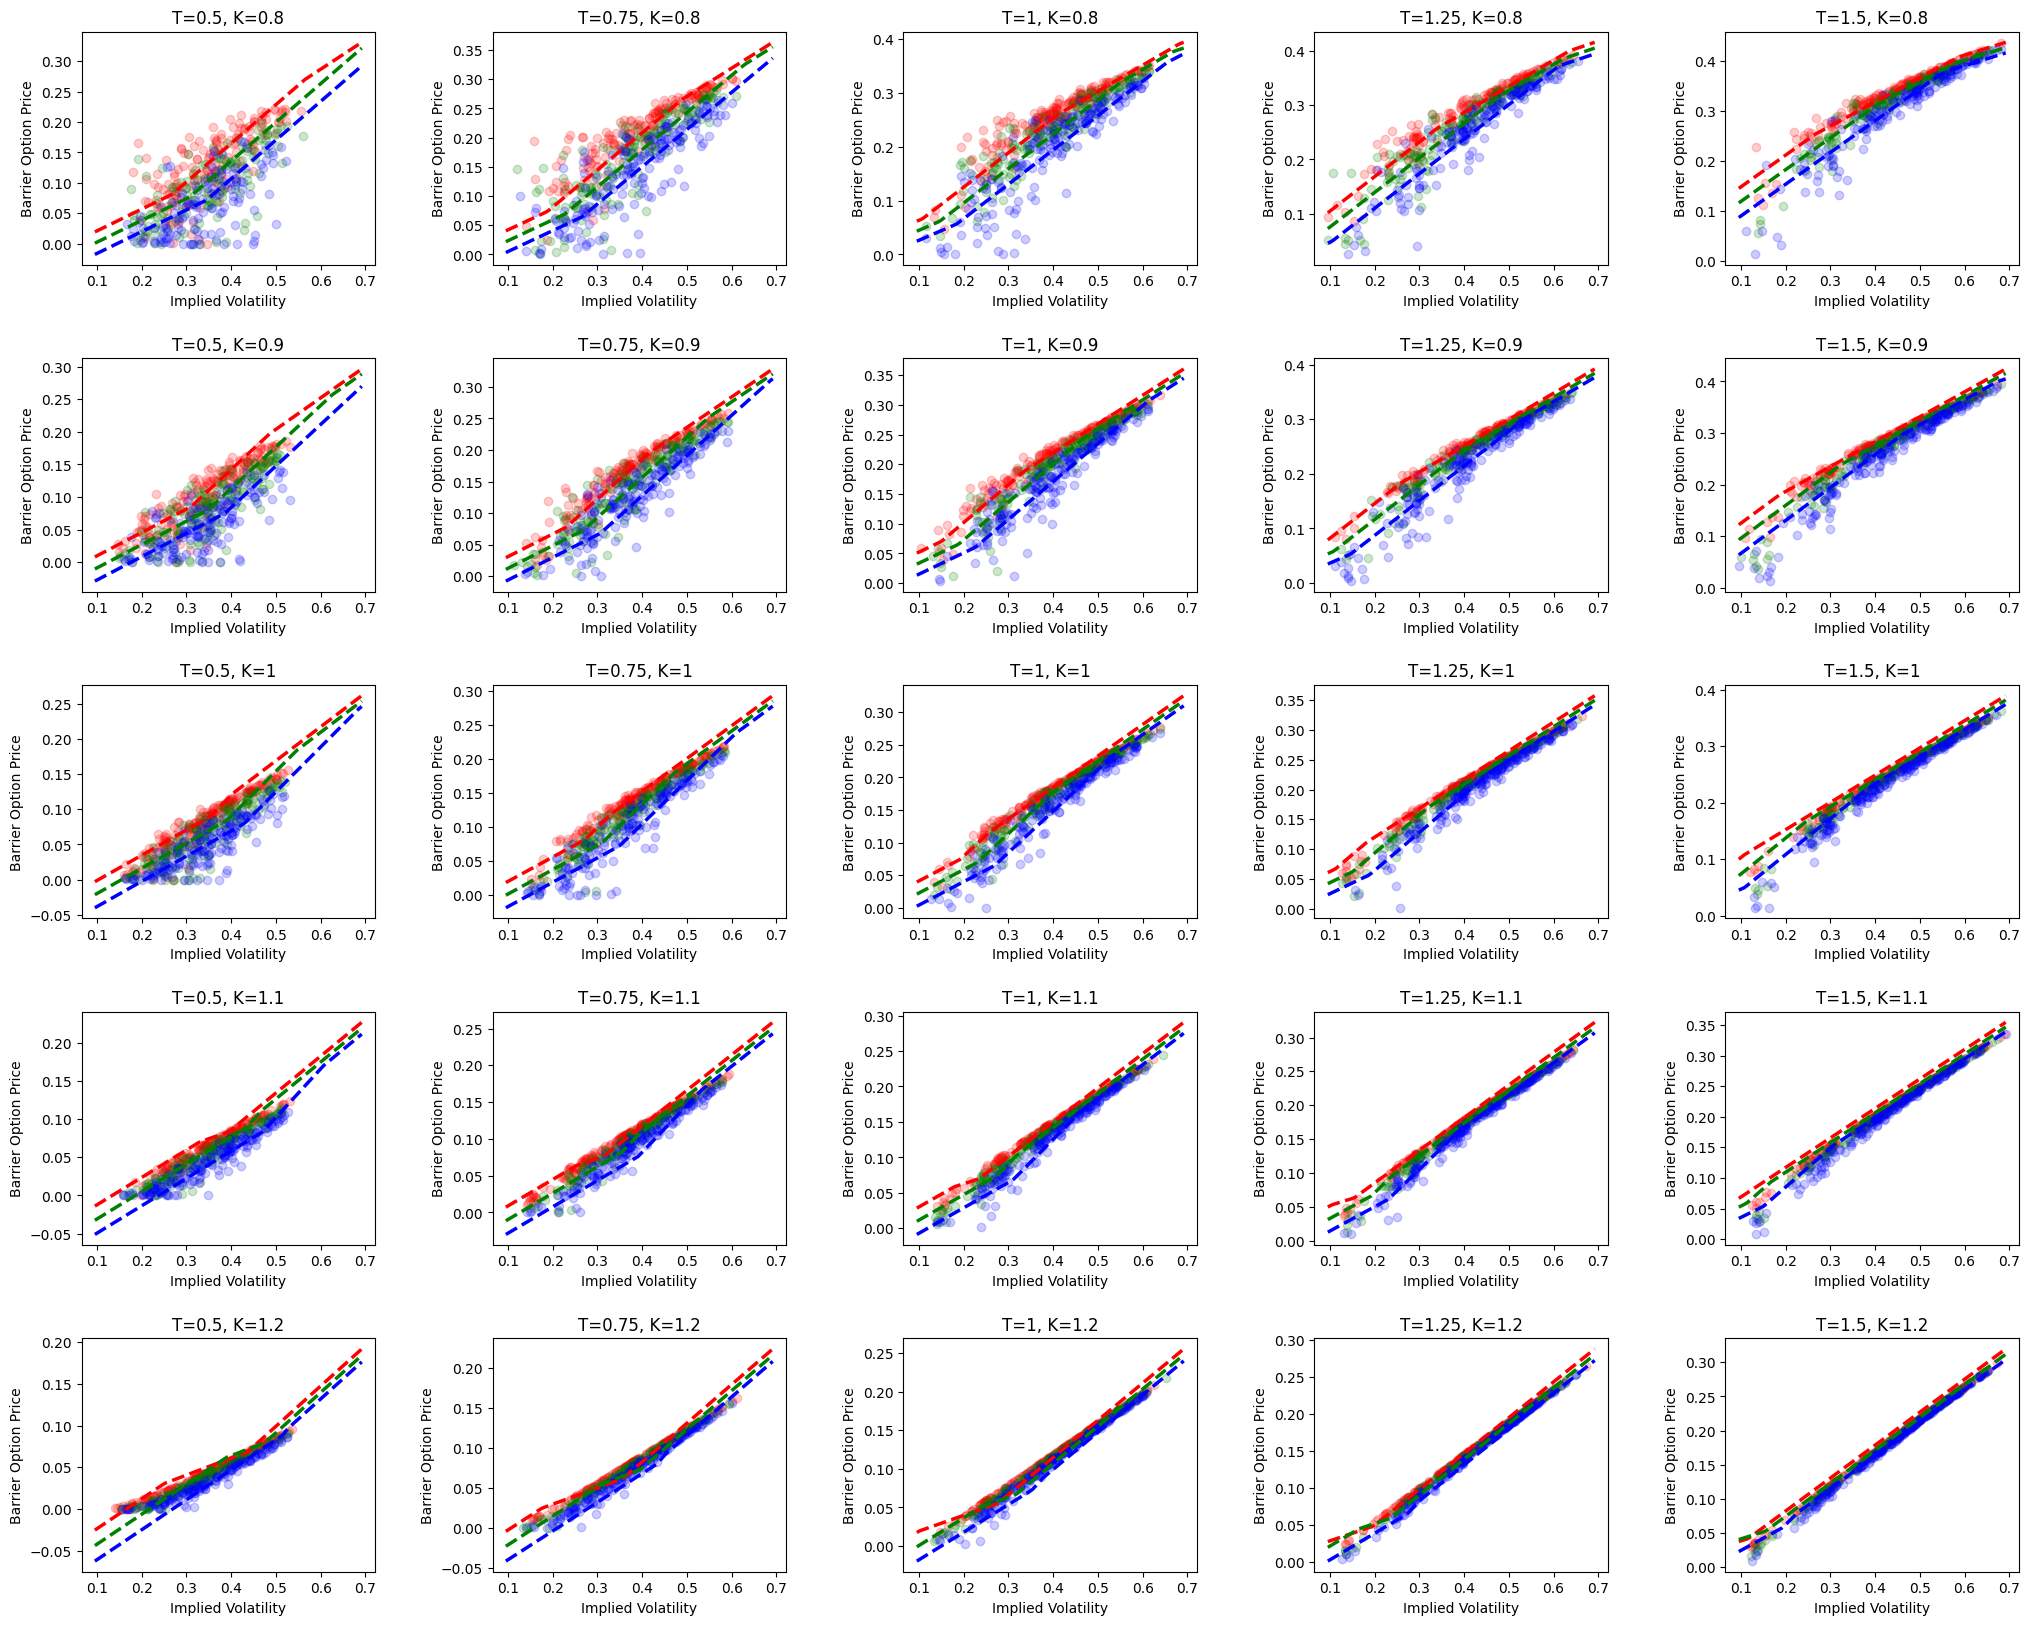

In [44]:
# Define the sets for T, K, and Barrier
T_values = [0.5, 0.75, 1, 1.25, 1.5]
K_values = [0.8, 0.9, 1, 1.1, 1.2]
Barrier_values = [1.3, 1.4, 1.5]
colors = ['red', 'green', 'blue', 'orange', 'purple']  # Colors for different barriers


min_vol = test_df['sigma_tk'].min()
max_vol = test_df['sigma_tk'].max()
vol_range = np.linspace(min_vol, max_vol, 100)


# Create subplots with 5 rows and 5 columns
fig, axes = plt.subplots(nrows=len(K_values), ncols=len(T_values), figsize=(25, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Iterate over each combination of T and K for subplots
for idx_k, K_fixed in enumerate(K_values):
    for idx_t, T_fixed in enumerate(T_values):
        ax = axes[idx_k, idx_t]

        for idx_b, Barrier_fixed in enumerate(Barrier_values):
            actual_prices = []
            actual_vols = []

            # Filter the dataset for the specific T, K, and Barrier combination
            filtered_df = test_df[(abs(test_df['T'] - T_fixed) < 1e-5) &
                                  (abs(test_df['K'] - K_fixed) < 1e-5) &
                                  (abs(test_df['B'] - Barrier_fixed) < 1e-5)]

            actual_prices = filtered_df['UI Barrier Price'].values
            actual_vols = filtered_df['sigma_tk'].values

            # Predict prices using the model for the given T, K, Barrier across the vol_range
            features_fixed = [(T_fixed, K_fixed, Barrier_fixed, vol) for vol in vol_range]
            features_fixed_tensor = torch.tensor(np.array(features_fixed), dtype=torch.float32)
            best_model.eval()
            with torch.no_grad():
                predicted_prices = best_model(features_fixed_tensor).numpy().flatten()

            # Plot actual data points
            if len(actual_prices) > 0:
                ax.scatter(actual_vols, actual_prices, color=colors[idx_b], label=f'Barrier={Barrier_fixed}', alpha=0.2)
            else:
                ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

            # Plot model predictions
            ax.plot(vol_range, predicted_prices, color=colors[idx_b], linestyle='--', linewidth=2.5)


        ax.set_title(f'T={T_fixed}, K={K_fixed}')
        ax.set_xlabel('Implied Volatility')
        ax.set_ylabel('Barrier Option Price')
        

# Display the entire grid of plots
plt.show()

## Testing the boundary conditions

In [73]:
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Predicted Barrier Price'])

# Reset the index of the test_df to ensure it aligns with the predictions
test_df_reset = test_df.reset_index(drop=True)

# Concatenate the original test DataFrame with the predictions
test_df_with_predictions = pd.concat([test_df_reset, predictions_df], axis=1)


test_df_with_predictions.to_csv('Results_constraints.csv', index=False)

## Saving Model

In [1]:
torch.save(best_model.state_dict(), "best_model_constraints.pth")


NameError: name 'torch' is not defined